In [1]:
import pickle
import unityneuro.render as urn
import numpy as np
import pandas as pd
from iblatlas.atlas import AllenAtlas
atlas = AllenAtlas(25)

# for comparisons
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.pyplot import figure

Downloading: C:\Users\Dan\Downloads\ONE\alyx.internationalbrainlab.org\histology\ATLAS\Needles\Allen\average_template_25.nrrd Bytes: 32998960


100%|██████████| 31.470260620117188/31.470260620117188 [00:02<00:00, 10.57it/s]


Downloading: C:\Users\Dan\Downloads\ONE\alyx.internationalbrainlab.org\histology\ATLAS\Needles\Allen\annotation_25.nrrd Bytes: 4035363


100%|██████████| 3.848422050476074/3.848422050476074 [00:00<00:00,  8.99it/s]


2022-11-07 18:19:25.630 INFO     [atlas.py:955] computing brain atlas annotations lookup table
2022-11-07 18:19:34.518 INFO     [atlas.py:979] Cached remapping file C:\Users\Dan\Downloads\ONE\alyx.internationalbrainlab.org\histology\ATLAS\Needles\Allen\annotation_25_lut_v01.npz ...


# Load data

In [2]:
with open('./data/Block_BWM_2022-06-01.p', 'rb') as file:
    data = pickle.load(file)

In [3]:
data

{'author': 'Brandon Benson',
 'date': '2022-06-01',
 'description': 'Logistic regression is used to decode the block from neural data.  accuracy values are reported after performing regression.  A 5-fold interleaved cross-validation is used to determine hyper-parameters on 80 percent of the data and predictions are made on the held-out 20 percent.  This is repeated 5 times with different held-out sets to cover all trials.  accuracy performance is then evaluated using the predictions across all trials.  The same process is used to decode 100 block pseudo-sessions which are used to evaluate the p-value of the reported accuracy value.',
 'inclusion_crit': 'Sessions must have 400 or more trials.  Trials with reaction time (firstMovement_time-goCue_time) less than 80ms are excluded. Unbiased blocks are excluded.  Regions with less than 10 units are excluded.  QC criteria is 3/3',
 'data':      probe                           session_eid acronym  score_accuracy  \
 0        0  1e45d992-c356-

In [4]:
areas = data['data']

# Setup data for renderer

In [5]:
# load beryl atlas, we only want areas in beryl (and we want *all* areas in beryl)
allenCCF = pd.read_csv('ontology_structure_minimal.csv')
berylIDs = np.unique(allenCCF.beryl_id.values)
berylAcronyms = atlas.regions.id2acronym(berylIDs,mapping='Beryl')
berylAcronyms = np.delete(berylAcronyms, np.argwhere(berylAcronyms=='root')[0][0])

In [6]:
# re-organize so that we have the accuracy/p-value per area
accData = {}
pvalData = {}
for i, row in areas.iterrows():
    if row.acronym in berylAcronyms:
        if row.acronym in accData.keys():
            accData[row.acronym].append(row.score_accuracy)
            pvalData[row.acronym].append(row.pvalue)
        else:
            accData[row.acronym] = [row.score_accuracy]
            pvalData[row.acronym] = [row.pvalue]

In [7]:
# get the median value
areaIntensity = {}
for area in accData.keys():
    areaIntensity[area] = np.median(accData[area])
minAcc = np.min(list(areaIntensity.values()))
maxAcc = np.max(list(areaIntensity.values()))
print(minAcc, maxAcc)
# get the percentage less than 0.05 p-value
pvalProportion = {}
for area in pvalData.keys():
    pvalProportion[area] = len(np.argwhere(np.array(pvalData[area])<0.05))/len(pvalData[area])

0.4076557971683311 0.682917012366165


In [8]:
# rescale intensity
for area in areaIntensity.keys():
    areaIntensity[area] = (areaIntensity[area]-minAcc) / (maxAcc-minAcc) + 0.01

In [9]:
for acronym in berylAcronyms:
    if not acronym in areaIntensity.keys():
        areaIntensity[acronym] = 0
    if not acronym in pvalProportion.keys():
        pvalProportion[acronym] = 0

In [19]:
areaNames = {}
areaMaterials = {}

suffixes = ['-lh','-rh']

for acronym in berylAcronyms:
    for suffix in suffixes:
        areaNames[acronym + suffix] = True
        areaMaterials[acronym + suffix] = "opaque-unlit"

# Render

In [11]:
urn.close()

In [12]:
urn.setup()

(URN) connected to server
Login sent with ID: Dan


In [15]:
urn.clear()

In [56]:
urn.set_area_visibility(areaNames)

In [57]:
urn.set_area_material(areaMaterials)

In [58]:
urn.set_area_colormap("grey-purple")
urn.set_area_intensity(areaIntensity)

In [39]:
urn.set_area_intensity(pvalProportion)

In [47]:
urn.set_area_intensity(areaIntensity)

In [48]:
urn.set_area_colormap("grey-red")
urn.set_area_intensity(pvalProportion)

In [60]:
urn.set_camera_rotation(45,0,0)

# Also render on swanson

<AxesSubplot:>

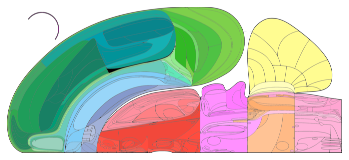

In [22]:
from iblatlas.plots import plot_swanson
from iblatlas.regions import BrainRegions
br = BrainRegions()

plot_swanson(br=br)

<AxesSubplot:>

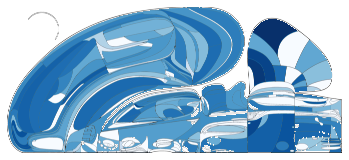

In [26]:
areas = list(areaIntensity.keys())
values = list(areaIntensity.values())
plot_swanson(areas, values, cmap='Blues', br=br)

In [34]:
# Let's create a new colormap that matches what we have in the unity renderer
# so 0=grey, and all other entries interpolate from light-purple to dark-purple

lightpurple = [202/255, 105/255, 227/255]
darkpurple = [141/255, 10/255, 157/255]
cdict = {'red':   [[0.0,  0.5, 0.5],
                   [1/255,  lightpurple[0], lightpurple[0]],
                   [1.0,  darkpurple[0], darkpurple[0]]],
         'green': [[0.0,  0.5, 0.5],
                   [1/255, lightpurple[1], lightpurple[1]],
                   [1.0, darkpurple[1], darkpurple[1]]],
         'blue':  [[0.0,  0.5, 0.5],
                   [1/255,  lightpurple[2], lightpurple[2]],
                   [1.0,  darkpurple[2], darkpurple[2]]]}
grey_purple_cmap = LinearSegmentedColormap('testCmap', segmentdata=cdict, N=256)

<AxesSubplot:>

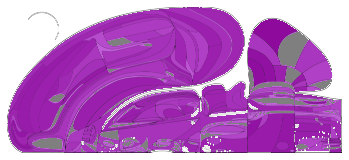

In [35]:
plot_swanson(areas, values, cmap=grey_purple_cmap, br=br)

<AxesSubplot:>

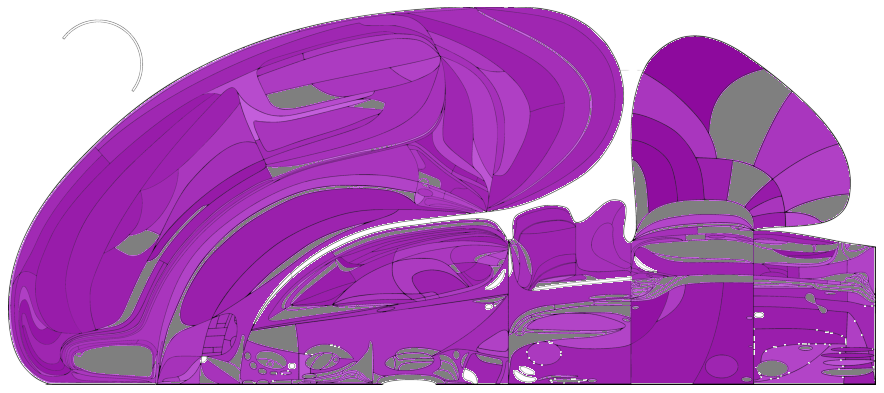

In [52]:
pvalues = list(pvalProportion.values())

figure(figsize=(14, 10), dpi=80)
plot_swanson(areas, values, cmap=grey_purple_cmap, br=br)

<AxesSubplot:>

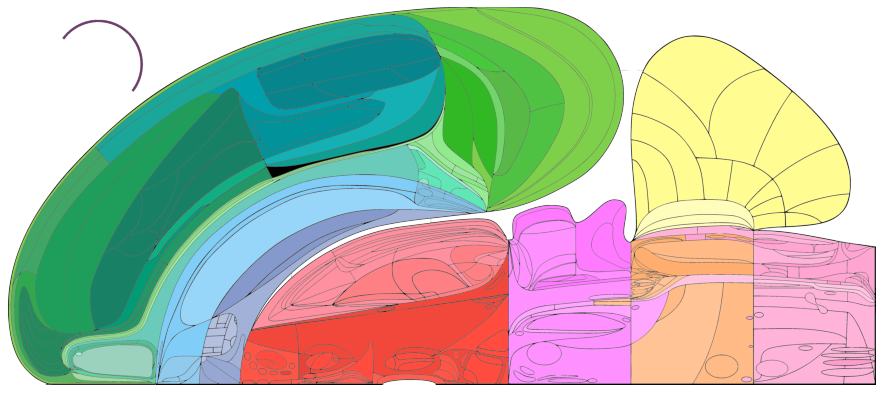

In [49]:
figure(figsize=(14, 10), dpi=80)
plot_swanson(br=br)

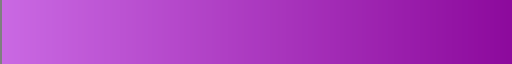

In [51]:
grey_purple_cmap

# Also render on CCF slices

In [53]:
from iblatlas.plots import plot_scalar_on_slice
from iblatlas.atlas import AllenAtlas
ba = AllenAtlas()

(0.0, 1.01)


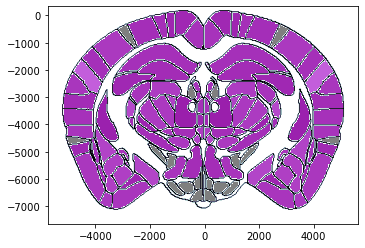

In [57]:
fig, ax = plot_scalar_on_slice(areas, np.array(values), coord=-2000, slice='coronal', mapping='Beryl',
                               hemisphere='both', background='boundary', cmap=grey_purple_cmap, brain_atlas=ba)

(0.0, 1.0)


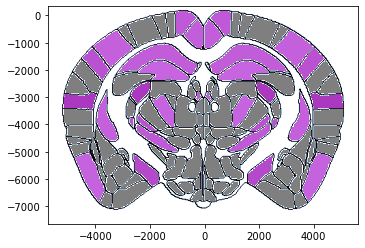

(URN) disconnected from server
(URN) connected to server
Login sent with ID: Dan


In [58]:
fig, ax = plot_scalar_on_slice(areas, np.array(pvalues), coord=-2000, slice='coronal', mapping='Beryl',
                               hemisphere='both', background='boundary', cmap=grey_purple_cmap, brain_atlas=ba)